# ML from scratch: Stable Diffusion, Day 2

### [Binxu Wang](https://scholar.harvard.edu/binxuw) and [John Vastola](https://twitter.com/johnjvastola)

<p align="center">
<img src="https://github.com/DrugowitschLab/ML-from-scratch-seminar/blob/master/StableDiffusion/images/astro.png?raw=true" alt="drawing" width="150"/>
<img src="https://github.com/DrugowitschLab/ML-from-scratch-seminar/blob/master/StableDiffusion/images/ballerina_chasing_cat.png?raw=true" alt="drawing" width="150"/>
<img src="https://github.com/DrugowitschLab/ML-from-scratch-seminar/blob/master/StableDiffusion/images/lovely_cat.png?raw=true" alt="drawing" width="150"/>
<img src="https://github.com/DrugowitschLab/ML-from-scratch-seminar/blob/master/StableDiffusion/images/turtle3.png?raw=true" alt="drawing" width="150"/>
</p>

On the first day, we went over the various components necessary to make an effective diffusion generative model like [Stable Diffusion](https://ommer-lab.com/research/latent-diffusion-models/).

As a reminder, they are:

- Method of learning to generate new stuff (forward/reverse diffusion)
- Way to link text and images (text-image representation model like [CLIP](https://github.com/openai/CLIP))
- Way to compress images (autoencoder)
- Way to add in good inductive biases (U-net architecture + self/cross-attention)

In today's session, you will implement pieces of each of the above, and by the end have a working Stable-Diffusion-like model.

In particular, you will implement parts of:

- **basic 1D forward/reverse diffusion**
- **a U-Net architecture for working with images**
- **the loss associated with learning the score function**
- **an attention model for conditional generation**
- **an autoencoder**

We need a reasonably small dataset so that training does not take forever, so we will be working with [MNIST](https://en.wikipedia.org/wiki/MNIST_database), a set of 28x28 images of handwritten 0-9 digits. By the end, our model should be able to take in a number prompt (e.g. "4") and output an image of the digit 4.

----------------

In [1]:
!pip install einops
!pip install lpips

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import functools

from torch.optim import Adam
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
import tqdm
from tqdm.notebook import trange, tqdm
from torch.optim.lr_scheduler import MultiplicativeLR, LambdaLR

import matplotlib.pyplot as plt

from torchvision.utils import make_grid


-------------------------------------------

## 4. Using attention to get conditional generation to work

In addition to generating images of e.g. 0-9 digits, we would like to do *conditional* generation: we would like to *specify* which digit we would like to generate an image of, for example.

Attention models, while not strictly necessary for conditional generation, have proven useful for getting it to work well. In this section, you will implement parts of an attention model.

In [3]:
from einops import rearrange
import math

### "Word embedding" of digits

Here, instead of using a fancy CLIP model, we just define our own vector representations of the digits 0-9.

We used the `nn.Embedding` layer to turn 0-9 index into vectors.

In [4]:
class WordEmbed(nn.Module):
  def __init__(self, vocab_size, embed_dim):
    super(WordEmbed, self).__init__()
    self.embed = nn.Embedding(vocab_size+1, embed_dim)

  def forward(self, ids):
    return self.embed(ids)

### Let's develop our Attention layer

We usually implement attention models using 3 parts:
* `CrossAttention`  Write a module to do self / cross attention for **sequences**.
* `TransformerBlock`  Combine self/cross-attention and a feed-forward neural network.
* `SpatialTransformer`  To use attention in a U-net, transform the spatial tensor to a sequential tensor and back.

**You will implement a part of the CrossAttention class**, and you will also pick where to add attention in your U-Net.

<p align="center">
<img src="https://github.com/DrugowitschLab/ML-from-scratch-seminar/blob/master/StableDiffusion/images/attention_pic1.png?raw=true" alt="drawing" width="850"/>
</p>

Here's a brief review of the mathematics of attention models. [QKV (query-key-value) attention models](https://stats.stackexchange.com/questions/421935/what-exactly-are-keys-queries-and-values-in-attention-mechanisms) represent queries, keys, and values as vectors. These are tools that help us relate words/images on one side of a translation task to the other side.

These are linearly related to $\mathbf{e}$ vectors (which represent the hidden state of the encoder) and $\mathbf{h}$ vectors (which represent the hidden state of the decoder):

\begin{equation}
\begin{split}
\mathbf{q}_i &= W_q \mathbf{h}_i \\
\mathbf{k}_j &= W_k \mathbf{e}_j \\
\mathbf{v}_j &= W_v \mathbf{e}_j \ .
\end{split}
\end{equation}

To figure out what to 'pay attention' to, we compute the inner product (i.e. similarity) of each key $\mathbf{k}$ and query $\mathbf{q}$. To get typical values that are not too big or too small, we normalize by the length/dimension of the query vectors $\mathbf{q}_i$.

The final attention distribution comes from softmax-ing all of this:

\begin{equation}
\begin{split}
a_{ij} &= \text{SoftMax}\left( \frac{\mathbf{k}_j \cdot \mathbf{q}_i}{\sqrt{\text{len}(\mathbf{q}_i)}} \right) \\
\sum_j a_{ij} &= 1
\end{split}
\end{equation}

The attention distribution is used to pick out some relevant combination of features. For example, in translating the phrase "European Union" from English to French, getting the correct answer ("Union européenne") requires paying attention to both words at once, instead of trying to translate each word totally separately. Mathematically, we weight values $\mathbf{v}_j$ by the attention distribution:

\begin{equation}
\mathbf{c}_i := \sum_j a_{ij} \mathbf{v}_j
\end{equation}

**Implement the missing pieces of the CrossAttention class below. Also implement the missing part of the TransformerBlock class.**

Note that the relevant matrix multiplications can be performed using `torch.einsum`. For example, to multiply an $M \times N$ matrix $A$ together with an $N \times N$ matrix $B$, i.e. to obtain $A B$, we can write:

`torch.einsum(ij,jk -> ik ,A, B)`

If, instead, we wanted to compute $A B^T$, we could write

`torch.einsum(ij,kj->ik ,A, B)`

The library takes care of moving the dimensions around properly. For machine learning, it is often important to do operations like matrix multiplication in batches. In this case, you can might have tensors instead of matrices, but you can write a very similar expression:

`torch.einsum(bij,bkj ,A, B)`

where `b` here is the index that describes which batch elements we are talking about. As a final point, you can use whatever letters you like instead of `i`, `j`, etc.

*Hint: `F.softmax` may also be helpful!*

### Attention Modules

In [7]:
class CrossAttention(nn.Module):
  def __init__(self, embed_dim, hidden_dim, context_dim=None, num_heads=1,):
    """
    Note: For simplicity reason, we just implemented 1-head attention.
    Feel free to implement multi-head attention! with fancy tensor manipulations.
    """
    super(CrossAttention, self).__init__()
    self.hidden_dim = hidden_dim
    self.context_dim = context_dim
    self.embed_dim = embed_dim
    self.query = nn.Linear(hidden_dim, embed_dim, bias=False)
    if context_dim is None:
      self.self_attn = True
      self.key = nn.Linear(hidden_dim, embed_dim, bias=False)     ###########
      self.value = nn.Linear(hidden_dim, hidden_dim, bias=False)  ############
    else:
      self.self_attn = False
      self.key = nn.Linear(context_dim, embed_dim, bias=False)   #############
      self.value = nn.Linear(context_dim, hidden_dim, bias=False) ############


  def forward(self, tokens, context=None):
    # tokens: with shape [batch, sequence_len, hidden_dim]
    # context: with shape [batch, contex_seq_len, context_dim]
    if self.self_attn:
        Q = self.query(tokens)
        K = self.key(tokens)
        V = self.value(tokens)
    else:
        # implement Q, K, V for the Cross attention
        Q = self.query(tokens)
        K = self.key(context)
        V = self.value(context)
    #print(Q.shape, K.shape, V.shape)
    ####### YOUR CODE HERE (2 lines)
    scoremats = torch.einsum("BTH,BSH->BTS", Q, K) # inner product of Q and K, a tensor
    attnmats = F.softmax(scoremats / math.sqrt(self.embed_dim), dim=-1) # softmax of scoremats
    #print(scoremats.shape, attnmats.shape, )
    ctx_vecs = torch.einsum("BTS,BSH->BTH", attnmats, V)  # weighted average value vectors by attnmats
    return ctx_vecs


class TransformerBlock(nn.Module):
  """The transformer block that combines self-attn, cross-attn and feed forward neural net"""
  def __init__(self, hidden_dim, context_dim):
    super(TransformerBlock, self).__init__()
    self.attn_self = CrossAttention(hidden_dim, hidden_dim, )
    self.attn_cross = CrossAttention(hidden_dim, hidden_dim, context_dim)

    self.norm1 = nn.LayerNorm(hidden_dim)
    self.norm2 = nn.LayerNorm(hidden_dim)
    self.norm3 = nn.LayerNorm(hidden_dim)
    # implement a 2 layer MLP with K*hidden_dim hidden units, and nn.GeLU nonlinearity #######
    self.ffn  = nn.Sequential(
        # YOUR CODE HERE ##################
        nn.Linear(hidden_dim, 3*hidden_dim),
        nn.GELU(),
        nn.Linear(3*hidden_dim, hidden_dim)
    )

  def forward(self, x, context=None):
    # Notice the + x as residue connections
    x = self.attn_self(self.norm1(x)) + x
    # Notice the + x as residue connections
    x = self.attn_cross(self.norm2(x), context=context) + x
    # Notice the + x as residue connections
    x = self.ffn(self.norm3(x)) + x
    return x

class SpatialTransformer(nn.Module):
  def __init__(self, hidden_dim, context_dim):
    super(SpatialTransformer, self).__init__()
    self.transformer = TransformerBlock(hidden_dim, context_dim)

  def forward(self, x, context=None):
    b, c, h, w = x.shape
    x_in = x
    # Combine the spatial dimensions and move the channel dimen to the end
    x = rearrange(x, "b c h w->b (h w) c")
    # Apply the sequence transformer
    x = self.transformer(x, context)
    # Reverse the process
    x = rearrange(x, 'b (h w) c -> b c h w', h=h, w=w)
    # Residue
    return x + x_in

Code play ground!

In [6]:
#@title Get some modules to let time interact

class GaussianFourierProjection(nn.Module):
  """Gaussian random features for encoding time steps."""
  def __init__(self, embed_dim, scale=30.):
    super().__init__()
    # Randomly sample weights (frequencies) during initialization.
    # These weights (frequencies) are fixed during optimization and are not trainable.
    self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)
  def forward(self, x):
    # Cosine(2 pi freq x), Sine(2 pi freq x)
    x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
    return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)


class Dense(nn.Module):
  """A fully connected layer that reshapes outputs to feature maps.
  Allow time repr to input additively from the side of a convolution layer.
  """
  def __init__(self, input_dim, output_dim):
    super().__init__()
    self.dense = nn.Linear(input_dim, output_dim)
  def forward(self, x):
    return self.dense(x)[..., None, None]
    # this broadcast the 2d tensor to 4d, add the same value across space.


### Putting it together, UNet Transformer

Now you can interleave your `SpatialTransformer` layers with the convolutional layers!

Remember to use them in your forward function. **Look at the architecture, and add in extra attention layers if you wish.**

In [8]:
class UNet_Tranformer(nn.Module):
  """A time-dependent score-based model built upon U-Net architecture."""

  def __init__(self, marginal_prob_std, channels=[32, 64, 128, 256], embed_dim=256,
               text_dim=256, nClass=10):
    """Initialize a time-dependent score-based network.

    Args:
      marginal_prob_std: A function that takes time t and gives the standard
        deviation of the perturbation kernel p_{0t}(x(t) | x(0)).
      channels: The number of channels for feature maps of each resolution.
      embed_dim: The dimensionality of Gaussian random feature embeddings of time.
      text_dim:  the embedding dimension of text / digits.
      nClass:    number of classes you want to model.
    """
    super().__init__()
    # Gaussian random feature embedding layer for time
    self.time_embed = nn.Sequential(
        GaussianFourierProjection(embed_dim=embed_dim),
        nn.Linear(embed_dim, embed_dim)
        )
    # Encoding layers where the resolution decreases
    self.conv1 = nn.Conv2d(1, channels[0], 3, stride=1, bias=False)
    self.dense1 = Dense(embed_dim, channels[0])
    self.gnorm1 = nn.GroupNorm(4, num_channels=channels[0])

    self.conv2 = nn.Conv2d(channels[0], channels[1], 3, stride=2, bias=False)
    self.dense2 = Dense(embed_dim, channels[1])
    self.gnorm2 = nn.GroupNorm(32, num_channels=channels[1])

    self.conv3 = nn.Conv2d(channels[1], channels[2], 3, stride=2, bias=False)
    self.dense3 = Dense(embed_dim, channels[2])
    self.gnorm3 = nn.GroupNorm(32, num_channels=channels[2])
    self.attn3 = SpatialTransformer(channels[2], text_dim)

    self.conv4 = nn.Conv2d(channels[2], channels[3], 3, stride=2, bias=False)
    self.dense4 = Dense(embed_dim, channels[3])
    self.gnorm4 = nn.GroupNorm(32, num_channels=channels[3])
    # YOUR CODE: interleave some attention layers with conv layers
    self.attn4 = SpatialTransformer(channels[3], text_dim) ######################################

    # Decoding layers where the resolution increases
    self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2], 3, stride=2, bias=False)
    self.dense5 = Dense(embed_dim, channels[2])
    self.tgnorm4 = nn.GroupNorm(32, num_channels=channels[2])

    self.tconv3 = nn.ConvTranspose2d(channels[2], channels[1], 3, stride=2, bias=False, output_padding=1)     #  + channels[2]
    self.dense6 = Dense(embed_dim, channels[1])
    self.tgnorm3 = nn.GroupNorm(32, num_channels=channels[1])

    self.tconv2 = nn.ConvTranspose2d(channels[1], channels[0], 3, stride=2, bias=False, output_padding=1)     #  + channels[1]
    self.dense7 = Dense(embed_dim, channels[0])
    self.tgnorm2 = nn.GroupNorm(32, num_channels=channels[0])
    self.tconv1 = nn.ConvTranspose2d(channels[0], 1, 3, stride=1) #  + channels[0]

    # The swish activation function
    self.act = nn.SiLU() # lambda x: x * torch.sigmoid(x)
    self.marginal_prob_std = marginal_prob_std
    self.cond_embed = nn.Embedding(nClass, text_dim)

  def forward(self, x, t, y=None):
    # Obtain the Gaussian random feature embedding for t
    embed = self.act(self.time_embed(t))
    y_embed = self.cond_embed(y).unsqueeze(1)
    # Encoding path
    h1 = self.conv1(x) + self.dense1(embed)
    ## Incorporate information from t
    ## Group normalization
    h1 = self.act(self.gnorm1(h1))
    h2 = self.conv2(h1) + self.dense2(embed)
    h2 = self.act(self.gnorm2(h2))
    h3 = self.conv3(h2) + self.dense3(embed)
    h3 = self.act(self.gnorm3(h3))
    h3 = self.attn3(h3, y_embed) # Use your attention layers
    h4 = self.conv4(h3) + self.dense4(embed)
    h4 = self.act(self.gnorm4(h4))
    # Your code: Use your additional attention layers!
    h4 = self.attn4(h4, y_embed) ##################### ATTENTION LAYER COULD GO HERE IF ATTN4 IS DEFINED

    # Decoding path
    h = self.tconv4(h4) + self.dense5(embed)
    ## Skip connection from the encoding path
    h = self.act(self.tgnorm4(h))
    h = self.tconv3(h + h3) + self.dense6(embed)
    h = self.act(self.tgnorm3(h))
    h = self.tconv2(h + h2) + self.dense7(embed)
    h = self.act(self.tgnorm2(h))
    h = self.tconv1(h + h1)

    # Normalize output
    h = h / self.marginal_prob_std(t)[:, None, None, None]
    return h

### Conditional Denoising Loss

Here, we need to modify the loss function by using the `y` information in the training.

In [9]:
def loss_fn_cond(model, x, y, marginal_prob_std, eps=1e-5):
  """The loss function for training score-based generative models.

  Args:
    model: A PyTorch model instance that represents a
      time-dependent score-based model.
    x: A mini-batch of training data.
    marginal_prob_std: A function that gives the standard deviation of
      the perturbation kernel.
    eps: A tolerance value for numerical stability.
  """
  random_t = torch.rand(x.shape[0], device=x.device) * (1. - eps) + eps
  z = torch.randn_like(x)
  std = marginal_prob_std(random_t)
  perturbed_x = x + z * std[:, None, None, None]
  score = model(perturbed_x, random_t, y=y)
  loss = torch.mean(torch.sum((score * std[:, None, None, None] + z)**2, dim=(1,2,3)))
  return loss

### Training a model that includes attention

In [10]:
#@title Diffusion constant and noise strength
device = 'cuda' #@param ['cuda', 'cpu'] {'type':'string'}

def marginal_prob_std(t, sigma):
  """Compute the mean and standard deviation of $p_{0t}(x(t) | x(0))$.

  Args:
    t: A vector of time steps.
    sigma: The $\sigma$ in our SDE.

  Returns:
    The standard deviation.
  """
  t = torch.tensor(t, device=device)
  return torch.sqrt((sigma**(2 * t) - 1.) / 2. / np.log(sigma))

def diffusion_coeff(t, sigma):
  """Compute the diffusion coefficient of our SDE.

  Args:
    t: A vector of time steps.
    sigma: The $\sigma$ in our SDE.

  Returns:
    The vector of diffusion coefficients.
  """
  return torch.tensor(sigma**t, device=device)

sigma =  25.0#@param {'type':'number'}
marginal_prob_std_fn = functools.partial(marginal_prob_std, sigma=sigma)
diffusion_coeff_fn = functools.partial(diffusion_coeff, sigma=sigma)

In [11]:
#@title Training model

continue_training = False #@param {type:"boolean"}
if not continue_training:
  print("initilize new score model...")
  score_model = torch.nn.DataParallel(UNet_Tranformer(marginal_prob_std=marginal_prob_std_fn))
  score_model = score_model.to(device)


n_epochs =   100#@param {'type':'integer'}
## size of a mini-batch
batch_size =  1024 #@param {'type':'integer'}
## learning rate
lr=10e-4 #@param {'type':'number'}

dataset = MNIST('.', train=True, transform=transforms.ToTensor(), download=True)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

optimizer = Adam(score_model.parameters(), lr=lr)
scheduler = LambdaLR(optimizer, lr_lambda=lambda epoch: max(0.2, 0.98 ** epoch))
tqdm_epoch = trange(n_epochs)
for epoch in tqdm_epoch:
  avg_loss = 0.
  num_items = 0
  for x, y in tqdm(data_loader):
    x = x.to(device)
    loss = loss_fn_cond(score_model, x, y, marginal_prob_std_fn)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    avg_loss += loss.item() * x.shape[0]
    num_items += x.shape[0]
  scheduler.step()
  lr_current = scheduler.get_last_lr()[0]
  print('{} Average Loss: {:5f} lr {:.1e}'.format(epoch, avg_loss / num_items, lr_current))
  # Print the averaged training loss so far.
  tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))
  # Update the checkpoint after each epoch of training.
  torch.save(score_model.state_dict(), 'ckpt_transformer.pth')

initilize new score model...
Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 18379489.96it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 496985.30it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4478586.44it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 3905397.45it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw




/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

<ipython-input-10-e9db09bfa051>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


0 Average Loss: 1090.785207 lr 9.8e-04


  0%|          | 0/59 [00:00<?, ?it/s]

1 Average Loss: 314.963933 lr 9.6e-04


  0%|          | 0/59 [00:00<?, ?it/s]

2 Average Loss: 204.921891 lr 9.4e-04


  0%|          | 0/59 [00:00<?, ?it/s]

3 Average Loss: 153.818363 lr 9.2e-04


  0%|          | 0/59 [00:00<?, ?it/s]

4 Average Loss: 123.840969 lr 9.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

5 Average Loss: 104.951625 lr 8.9e-04


  0%|          | 0/59 [00:00<?, ?it/s]

6 Average Loss: 90.722120 lr 8.7e-04


  0%|          | 0/59 [00:00<?, ?it/s]

7 Average Loss: 80.388798 lr 8.5e-04


  0%|          | 0/59 [00:00<?, ?it/s]

8 Average Loss: 72.564639 lr 8.3e-04


  0%|          | 0/59 [00:00<?, ?it/s]

9 Average Loss: 65.909080 lr 8.2e-04


  0%|          | 0/59 [00:00<?, ?it/s]

10 Average Loss: 61.408576 lr 8.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

11 Average Loss: 56.257362 lr 7.8e-04


  0%|          | 0/59 [00:00<?, ?it/s]

12 Average Loss: 53.165997 lr 7.7e-04


  0%|          | 0/59 [00:00<?, ?it/s]

13 Average Loss: 50.243890 lr 7.5e-04


  0%|          | 0/59 [00:00<?, ?it/s]

14 Average Loss: 47.604891 lr 7.4e-04


  0%|          | 0/59 [00:00<?, ?it/s]

15 Average Loss: 45.606977 lr 7.2e-04


  0%|          | 0/59 [00:00<?, ?it/s]

16 Average Loss: 42.808113 lr 7.1e-04


  0%|          | 0/59 [00:00<?, ?it/s]

17 Average Loss: 41.898452 lr 7.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

18 Average Loss: 40.366841 lr 6.8e-04


  0%|          | 0/59 [00:00<?, ?it/s]

19 Average Loss: 39.535517 lr 6.7e-04


  0%|          | 0/59 [00:00<?, ?it/s]

20 Average Loss: 38.424204 lr 6.5e-04


  0%|          | 0/59 [00:00<?, ?it/s]

21 Average Loss: 37.471760 lr 6.4e-04


  0%|          | 0/59 [00:00<?, ?it/s]

22 Average Loss: 36.557546 lr 6.3e-04


  0%|          | 0/59 [00:00<?, ?it/s]

23 Average Loss: 35.527333 lr 6.2e-04


  0%|          | 0/59 [00:00<?, ?it/s]

24 Average Loss: 35.057172 lr 6.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

25 Average Loss: 34.461617 lr 5.9e-04


  0%|          | 0/59 [00:00<?, ?it/s]

26 Average Loss: 33.905190 lr 5.8e-04


  0%|          | 0/59 [00:00<?, ?it/s]

27 Average Loss: 33.056117 lr 5.7e-04


  0%|          | 0/59 [00:00<?, ?it/s]

28 Average Loss: 32.444083 lr 5.6e-04


  0%|          | 0/59 [00:00<?, ?it/s]

29 Average Loss: 31.949742 lr 5.5e-04


  0%|          | 0/59 [00:00<?, ?it/s]

30 Average Loss: 31.840967 lr 5.3e-04


  0%|          | 0/59 [00:00<?, ?it/s]

31 Average Loss: 31.317398 lr 5.2e-04


  0%|          | 0/59 [00:00<?, ?it/s]

32 Average Loss: 30.573620 lr 5.1e-04


  0%|          | 0/59 [00:00<?, ?it/s]

33 Average Loss: 30.319995 lr 5.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

34 Average Loss: 30.164081 lr 4.9e-04


  0%|          | 0/59 [00:00<?, ?it/s]

35 Average Loss: 29.720333 lr 4.8e-04


  0%|          | 0/59 [00:00<?, ?it/s]

36 Average Loss: 29.258138 lr 4.7e-04


  0%|          | 0/59 [00:00<?, ?it/s]

37 Average Loss: 28.806482 lr 4.6e-04


  0%|          | 0/59 [00:00<?, ?it/s]

38 Average Loss: 28.846517 lr 4.5e-04


  0%|          | 0/59 [00:00<?, ?it/s]

39 Average Loss: 28.776759 lr 4.5e-04


  0%|          | 0/59 [00:00<?, ?it/s]

40 Average Loss: 28.314859 lr 4.4e-04


  0%|          | 0/59 [00:00<?, ?it/s]

41 Average Loss: 27.850565 lr 4.3e-04


  0%|          | 0/59 [00:00<?, ?it/s]

42 Average Loss: 27.819474 lr 4.2e-04


  0%|          | 0/59 [00:00<?, ?it/s]

43 Average Loss: 27.308062 lr 4.1e-04


  0%|          | 0/59 [00:00<?, ?it/s]

44 Average Loss: 27.204928 lr 4.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

45 Average Loss: 27.102180 lr 3.9e-04


  0%|          | 0/59 [00:00<?, ?it/s]

46 Average Loss: 27.002146 lr 3.9e-04


  0%|          | 0/59 [00:00<?, ?it/s]

47 Average Loss: 26.512712 lr 3.8e-04


  0%|          | 0/59 [00:00<?, ?it/s]

48 Average Loss: 26.575496 lr 3.7e-04


  0%|          | 0/59 [00:00<?, ?it/s]

49 Average Loss: 25.923101 lr 3.6e-04


  0%|          | 0/59 [00:00<?, ?it/s]

50 Average Loss: 26.086328 lr 3.6e-04


  0%|          | 0/59 [00:00<?, ?it/s]

51 Average Loss: 26.055537 lr 3.5e-04


  0%|          | 0/59 [00:00<?, ?it/s]

52 Average Loss: 25.660936 lr 3.4e-04


  0%|          | 0/59 [00:00<?, ?it/s]

53 Average Loss: 25.286942 lr 3.4e-04


  0%|          | 0/59 [00:00<?, ?it/s]

54 Average Loss: 25.300600 lr 3.3e-04


  0%|          | 0/59 [00:00<?, ?it/s]

55 Average Loss: 25.285287 lr 3.2e-04


  0%|          | 0/59 [00:00<?, ?it/s]

56 Average Loss: 25.010027 lr 3.2e-04


  0%|          | 0/59 [00:00<?, ?it/s]

57 Average Loss: 24.906604 lr 3.1e-04


  0%|          | 0/59 [00:00<?, ?it/s]

58 Average Loss: 24.893016 lr 3.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

59 Average Loss: 24.505730 lr 3.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

60 Average Loss: 24.568523 lr 2.9e-04


  0%|          | 0/59 [00:00<?, ?it/s]

61 Average Loss: 24.505415 lr 2.9e-04


  0%|          | 0/59 [00:00<?, ?it/s]

62 Average Loss: 24.351829 lr 2.8e-04


  0%|          | 0/59 [00:00<?, ?it/s]

63 Average Loss: 24.220530 lr 2.7e-04


  0%|          | 0/59 [00:00<?, ?it/s]

64 Average Loss: 23.992621 lr 2.7e-04


  0%|          | 0/59 [00:00<?, ?it/s]

65 Average Loss: 24.166406 lr 2.6e-04


  0%|          | 0/59 [00:00<?, ?it/s]

66 Average Loss: 23.717279 lr 2.6e-04


  0%|          | 0/59 [00:00<?, ?it/s]

67 Average Loss: 23.688989 lr 2.5e-04


  0%|          | 0/59 [00:00<?, ?it/s]

68 Average Loss: 23.364571 lr 2.5e-04


  0%|          | 0/59 [00:00<?, ?it/s]

69 Average Loss: 23.249325 lr 2.4e-04


  0%|          | 0/59 [00:00<?, ?it/s]

70 Average Loss: 23.203094 lr 2.4e-04


  0%|          | 0/59 [00:00<?, ?it/s]

71 Average Loss: 22.944791 lr 2.3e-04


  0%|          | 0/59 [00:00<?, ?it/s]

72 Average Loss: 23.254746 lr 2.3e-04


  0%|          | 0/59 [00:00<?, ?it/s]

73 Average Loss: 23.019390 lr 2.2e-04


  0%|          | 0/59 [00:00<?, ?it/s]

74 Average Loss: 22.623084 lr 2.2e-04


  0%|          | 0/59 [00:00<?, ?it/s]

75 Average Loss: 22.869766 lr 2.2e-04


  0%|          | 0/59 [00:00<?, ?it/s]

76 Average Loss: 22.710161 lr 2.1e-04


  0%|          | 0/59 [00:00<?, ?it/s]

77 Average Loss: 22.779305 lr 2.1e-04


  0%|          | 0/59 [00:00<?, ?it/s]

78 Average Loss: 22.414772 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

79 Average Loss: 22.546151 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

80 Average Loss: 22.085017 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

81 Average Loss: 22.103677 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

82 Average Loss: 22.021790 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

83 Average Loss: 22.360184 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

84 Average Loss: 21.944746 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

85 Average Loss: 21.858870 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

86 Average Loss: 21.967220 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

87 Average Loss: 21.961735 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

88 Average Loss: 21.713206 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

89 Average Loss: 21.512956 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

90 Average Loss: 21.638787 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

91 Average Loss: 21.499266 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

92 Average Loss: 21.780311 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

93 Average Loss: 21.300976 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

94 Average Loss: 21.436932 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

95 Average Loss: 21.230213 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

96 Average Loss: 21.317114 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

97 Average Loss: 21.129167 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

98 Average Loss: 21.031325 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

99 Average Loss: 20.987519 lr 2.0e-04


Loss around 23 at 67 epochs (without lr tuning, around 150 epochs reach 23)

In [12]:
def visualize_digit_embedding(digit_embed):
  cossim_mat = []
  for i in range(10):
    cossim = torch.cosine_similarity(digit_embed, digit_embed[i:i+1,:]).cpu()
    cossim_mat.append(cossim)
  cossim_mat = torch.stack(cossim_mat)
  cossim_mat_nodiag = cossim_mat + torch.diag_embed(torch.nan * torch.ones(10))
  plt.imshow(cossim_mat_nodiag)
  plt.show()
  return cossim_mat

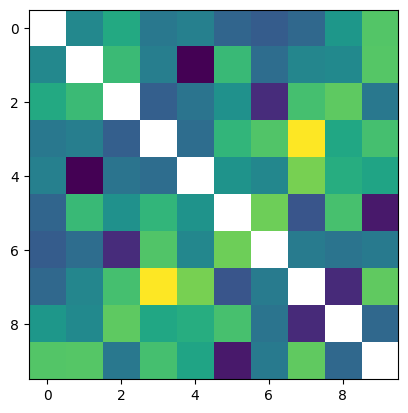

In [13]:
cossim_mat = visualize_digit_embedding(score_model.module.cond_embed.weight.data)

### Examine Samples

In [14]:
#@title Sampler code
num_steps = 500#@param {'type':'integer'}
def Euler_Maruyama_sampler(score_model,
              marginal_prob_std,
              diffusion_coeff,
              batch_size=64,
              x_shape=(1, 28, 28),
              num_steps=num_steps,
              device='cuda',
              eps=1e-3, y=None):
  """Generate samples from score-based models with the Euler-Maruyama solver.

  Args:
    score_model: A PyTorch model that represents the time-dependent score-based model.
    marginal_prob_std: A function that gives the standard deviation of
      the perturbation kernel.
    diffusion_coeff: A function that gives the diffusion coefficient of the SDE.
    batch_size: The number of samplers to generate by calling this function once.
    num_steps: The number of sampling steps.
      Equivalent to the number of discretized time steps.
    device: 'cuda' for running on GPUs, and 'cpu' for running on CPUs.
    eps: The smallest time step for numerical stability.

  Returns:
    Samples.
  """
  t = torch.ones(batch_size, device=device)
  init_x = torch.randn(batch_size, *x_shape, device=device) \
    * marginal_prob_std(t)[:, None, None, None]
  time_steps = torch.linspace(1., eps, num_steps, device=device)
  step_size = time_steps[0] - time_steps[1]
  x = init_x
  with torch.no_grad():
    for time_step in tqdm(time_steps):
      batch_time_step = torch.ones(batch_size, device=device) * time_step
      g = diffusion_coeff(batch_time_step)
      mean_x = x + (g**2)[:, None, None, None] * score_model(x, batch_time_step, y=y) * step_size
      x = mean_x + torch.sqrt(step_size) * g[:, None, None, None] * torch.randn_like(x)
  # Do not include any noise in the last sampling step.
  return mean_x

Here is some code we can use to see how well the model does conditional generation. You can use the menu on the right to choose what you want to generate.

In [17]:
def save_samples_cond(score_model, num_steps):
  score_model.eval()
  for digit in range(10):
    ## Generate samples using the specified sampler.
    sample_batch_size = 64 #@param {'type':'integer'}
    sampler = Euler_Maruyama_sampler #@param ['Euler_Maruyama_sampler', 'pc_sampler', 'ode_sampler'] {'type': 'raw'}
    # score_model.eval()
    ## Generate samples using the specified sampler.
    samples = sampler(score_model,
            marginal_prob_std_fn,
            diffusion_coeff_fn,
            sample_batch_size,
            num_steps=num_steps,
            device=device,
            y=digit*torch.ones(sample_batch_size, dtype=torch.long))

        ## Sample visualization.
    samples = samples.clamp(0.0, 1.0)
    sample_grid = make_grid(samples, nrow=int(np.sqrt(sample_batch_size)))
    sample_np = sample_grid.permute(1, 2, 0).cpu().numpy()
    plt.imsave(f"condition_diffusion_digit%d.png"%digit, sample_np,)
    plt.figure(figsize=(6,6))
    plt.axis('off')
    plt.imshow(sample_np, vmin=0., vmax=1.)
    plt.show()


In [18]:
score_model = torch.nn.DataParallel(UNet_Tranformer(marginal_prob_std=marginal_prob_std_fn))
score_model.load_state_dict(torch.load("ckpt_transformer.pth"))
save_samples_cond(score_model, num_steps = 250)

Output hidden; open in https://colab.research.google.com to view.

In [20]:
score_model = torch.nn.DataParallel(UNet_Tranformer(marginal_prob_std=marginal_prob_std_fn))
score_model.load_state_dict(torch.load("ckpt_transformer.pth"))
save_samples_cond(score_model, num_steps = 500)

Output hidden; open in https://colab.research.google.com to view.

--------------------